In [1]:
import tensorflow as tf
import os
import random
import numpy as np

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

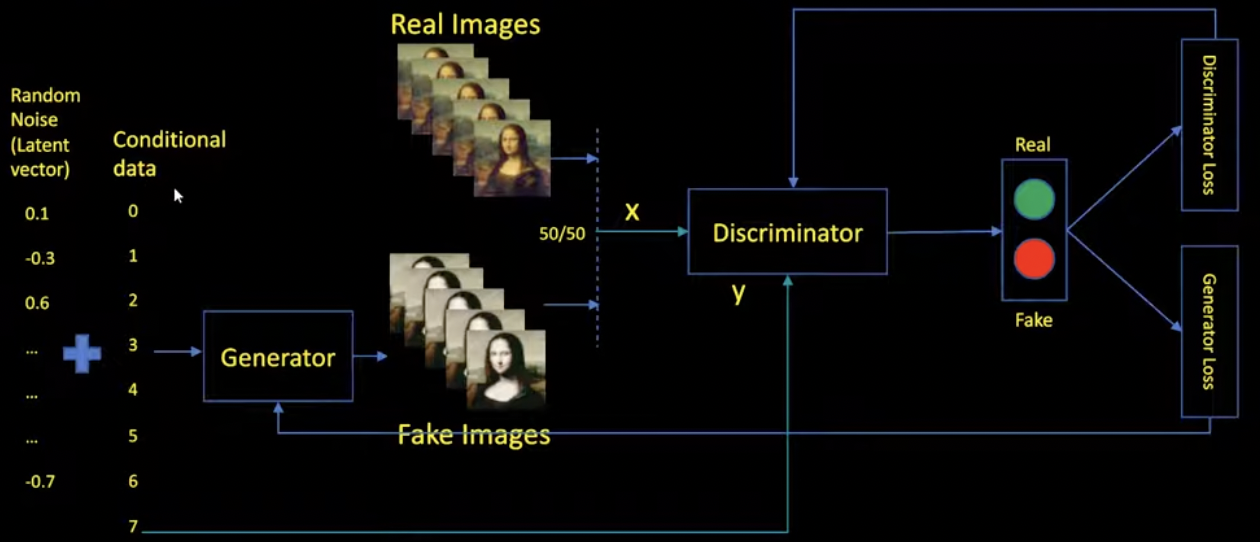

In [2]:
def define_discriminant(in_shape=(32, 32, 3)):
    """
        Just an ordinary binary classifier to discriminate between 
        true and fake images
    """
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding='same', 
            strides=(2, 2), input_shape=in_shape
        )
    )
    model.add(
        tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding='same', 
            strides=(2, 2)
        )
    )
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(rate=0.4))
    model.add(tf.keras.layers.Dense(units=1, activation='relu'))
    
    # Compile
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002,
                                        beta_1=0.5)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [3]:
def define_generator(latent_dim):
    model = tf.keras.Sequential()
    n_nodes = 128*8*8
    model.add(
        tf.keras.layers.Dense(n_nodes, input_shape=(latent_dim,))
    )
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Reshape((8, 8, 128)))
    
    model.add(
        tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=2, 
                                        padding='same')
    )
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(
        tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=2, 
                                        padding='same')
    )
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(
        tf.keras.layers.Conv2D(3, (8, 8), strides=2, 
                               padding='same', 
                               activation='tanh')
    )
    
    return model

In [4]:
def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = tf.keras.Sequential()
    model.add(generator)
    model.add(discriminator)
    # Compile
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002,
                                        beta_1=0.5)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [5]:
def load_real_samples():
    X = []
    for file in os.listdir(PATH):
        img = plt.imread(PATH+file)
        img = cv2.resize(img, (32, 32),
                   interpolation = cv2.INTER_LINEAR)
        img = img.astype('float32')
        img = (img - 127.5)/127.5
        X.append(img)
    return X

In [6]:
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = tf.ones((n_samples, 1))
    return X, y

In [7]:
def generate_latent_points(latent_dim, n_samples):
    x_input = np.randn(latent_dim*n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [8]:
def generate_fake_points(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    x = generator.predict(x_input)
    y = tf.zeros((n_samples, 1))
    return X, y

In [9]:
def train(g_model, d_model, gan_model, dataset, 
          latent_dim, n_epochs=100, n_batches=128):
    bat_per_epoch = int(dataset.shape[0]/n_batches)
    half_batch = int(n_batches/2)
    for i in range(n_epochs):
        for j in range(bat_per_epoch):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss_real, _ = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_points(g_model, latent_dim, half_batch)
            d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            X_gan = generate_latent_points(latent_dim, n_batches)
            y_gan = tf.ones((n_batches, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            print(f'EPOCH [{i}/{n_epochs}]: Batch {j}/{bat_per_epoch}, d1={d_loss_real:.3f}, d2={d_loss_fake:.3f}, g={g_loss}')
            

In [11]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminant()
# create the generato
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=2)

Metal device set to: Apple M1


ValueError: Exception encountered when calling layer "sequential" (type Sequential).

Input 0 of layer "dense" is incompatible with the layer: expected axis -1of input shape to have value 8192, but received input with shape (None, 2048)

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 16, 16, 3), dtype=float32)
  • training=None
  • mask=None